## Pybamm aging experiment

Experimento básico para demonstrar um pouco da simulação de envelhecimento no PyBaMM.

Demonstração baseada no modelo de [O'Kane et al 2020](https://doi.org/10.1149/1945-7111/ab90ac). Mistura de modelos de degradação que interagem. Meu entedimento é que esses modelos e parametros são mais ilustrativos, não necessariamente refletem uma bateria real.

In [14]:
import jax
import pybamm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# model with options dict
model = pybamm.lithium_ion.DFN(
    {
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
    }
)

param = pybamm.ParameterValues("OKane2022")

In [13]:
cycle_number = 20
exp = pybamm.Experiment(
    [
        "Hold at 4.2 V until C/100 (5 minute period)",
        "Rest for 4 hours (5 minute period)",
        "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
        "Charge at 0.3C until 4.2 V (5 minute period)",
        "Hold at 4.2 V until C/100 (5 minute period)",
    ]
    + [
        (
            "Discharge at 1C until 2.5 V (1 minute period)",  # ageing cycles
            "Charge at 0.3C until 4.2 V (5 minute period)",
            "Hold at 4.2 V until C/100 (5 minute period)",
        )
    ]
    * cycle_number
    + ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)

# solver -- lib usada p/ resolver eq. diferenciais
solver = pybamm.CasadiSolver()
sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, solver=solver)
sol = sim.solve()

At t = 489.411 and h = 6.36975e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 428.768 and h = 9.18979e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 188.768 and h = 9.15302e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 428.169 and h = 9.63377e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 188.163 and h = 9.23835e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 427.605 and h = 1.03848e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.6 and h = 2.26675e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 427.069 and h = 4.66838e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 113.767 and h = 3.20602e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 426.556 and h = 1.74305e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

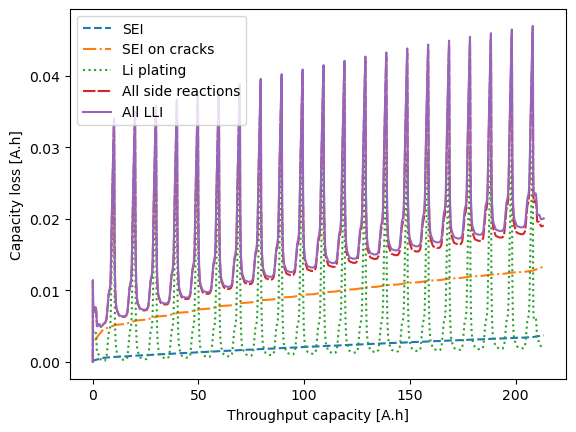

In [15]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h
plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

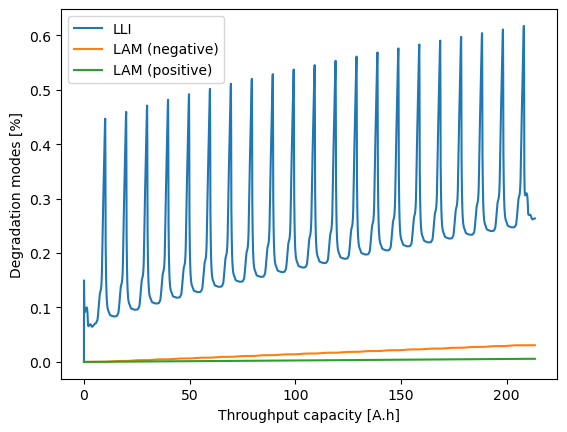

In [16]:
Qt = sol["Throughput capacity [A.h]"].entries
LLI = sol["Loss of lithium inventory [%]"].entries
LAM_neg = sol["Loss of active material in negative electrode [%]"].entries
LAM_pos = sol["Loss of active material in positive electrode [%]"].entries
plt.figure()
plt.plot(Qt, LLI, label="LLI")
plt.plot(Qt, LAM_neg, label="LAM (negative)")
plt.plot(Qt, LAM_pos, label="LAM (positive)")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Degradation modes [%]")
plt.legend()
plt.show()

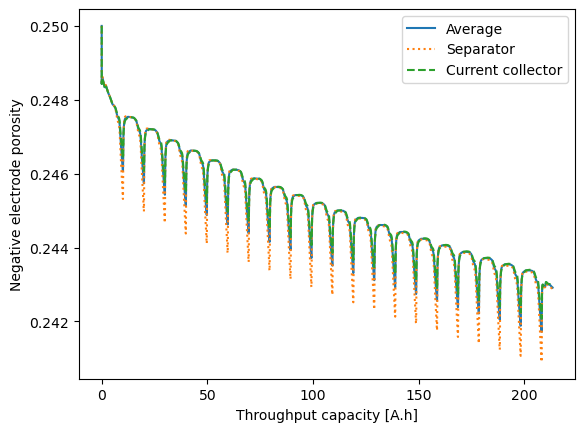

In [17]:
eps_neg_avg = sol["X-averaged negative electrode porosity"].entries
eps_neg_sep = sol["Negative electrode porosity"].entries[-1, :]
eps_neg_CC = sol["Negative electrode porosity"].entries[0, :]
plt.figure()
plt.plot(Qt, eps_neg_avg, label="Average")
plt.plot(Qt, eps_neg_sep, label="Separator", linestyle="dotted")
plt.plot(Qt, eps_neg_CC, label="Current collector", linestyle="dashed")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Negative electrode porosity")
plt.legend()
plt.show()

In [18]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical S